In [19]:
from scipy.integrate import solve_ivp
import numpy as np
import pandas as pd
from pydantic import BaseModel, ValidationError, validator, confloat, Field
from pydantic.schema import schema

In [22]:
class I:
    U = 0
    FL = 1
    SL = 2
    Sym = 3
    Rec = 4


class Intv0(BaseModel):
    scale: confloat(strict=True, ge=0, le=1) = Field(
        default=0,
        title='Coverage',
        description='The coverage of the intervention'
    )
    

class Demand(Intv0):
    def impluse(self, r_det):
        return r_det


class RedRel(Intv0):
    def impluse(self, r_react, r_rel):
        return r_react, r_rel


class Interventions(BaseModel):
    Year0: float = 2019
    Year1: float = 2030
    YearI0: float = 2022
    YearI1: float = 2025
    Demand: Demand = Demand()
    RedRel: RedRel = RedRel()
        
    def do_actions(self, t, r_react, r_rel, r_det):
        r_react1, r_rel1 = self.RedRel.impulse(r_react, r_rel)
        r_det1 = self.Demand.impulse(r_det)
        
        wt = self.calc_wt(t)
        r_react = self.scale_up(r_react, r_react1, wt)
        r_rel = self.scale_up(r_rel, r_rel1, wt)
        r_det = self.scale_up(r_det, r_det1, wt)
        
        return r_react, r_rel, r_det
    
    def calc_wt(self, t):
        if t < self.YearI0:
            return 0
        elif t > self.YearI1:
            return 1
        else:
            return (t - self.YearI0) / (self.YearI1 - self.YearI0)
        
    def scale_up(v0, v1, wt):
        return v0 + wt * (v1 - v0)
        
    

In [32]:
intv = Interventions.parse_obj({'Year0': 2023})
intv.dict()

{'Year0': 2023.0, 'Demand': {'scale': 0}, 'RedRel': {'scale': 0}}

In [33]:
?Interventions

In [30]:
x = np.array([5])
y = x
x += 1
x, y

(array([6]), array([6]))

In [32]:
class Model:
    def __init__(self, year0 = 250):
        self.Year0 = year0
        self.Intv = None
    
    def get_y0(self):
        return np.array([99900, 0, 0, 100, 0])
    
    def collect_calc(self, t, y, pars):
        calc = dict()
        
        foi = pars['beta'] * y[I.Sym] / y.sum()
        
        if t > 250:
            foi *= np.exp(- pars['adr'] * (t - 250))
        
        infections = foi * np.array([1, 0, 0.2, 0, 0.2]) * y
        
        calc['infections'] = infections
        calc['lat'] = pars['r_lat'] * y[I.FL]
        calc['act'] = pars['r_act'] * y[I.FL]
        calc['react'] = pars['r_react'] * y[I.SL]
        calc['rel'] = pars['r_rel'] * y[I.Rec]
        calc['det'] = pars['r_det'] * y[I.Sym]
        calc['deaths'] = pars['mu'] * y
        return calc
    
    def __call__(self, t, y, pars):
        calc = self.collect_calc(t, y, pars)
        
        dy = np.zeros(5)
        dy -= calc['infections']
        dy[I.FL] += calc['infections'].sum() - calc['act'] - calc['lat']
        dy[I.SL] += calc['lat'] - calc['react']
        dy[I.Sym] += calc['act'] + calc['react'] + calc['rel'] - calc['det']
        dy[I.Rec] += calc['det'] - calc['rel']
        
        dy -= calc['deaths']
        dy[I.U] += calc['deaths'].sum()
        
        return dy
        
    
    def measure(self, t, y, pars):
        n = y.sum()
        
        calc = self.collect_calc(t, y, pars)
        
        inc = calc['act'] + calc['react'] + calc['rel']
        
        return {
            'Year': t,
            'Prev': y[I.Sym] / n,
            'IncR': inc / n
        }
    
    
    
def simulate(model, pars, intv = None):
    model.Intv = intv
    y0 = model.get_y0()

    sol = solve_ivp(model, [0, 300], y0, t_eval = np.linspace(0, 300, 3001), args = (pars, ), dense_output = True)

    meas = list()

    for t in sol.t:
        if t > 250:
            meas.append(model.measure(t, sol.sol(t), pars))

    meas = pd.DataFrame(meas)
    meas = meas.set_index('Year')
    model.Intv = intv
    return meas

<AxesSubplot:xlabel='Year'>

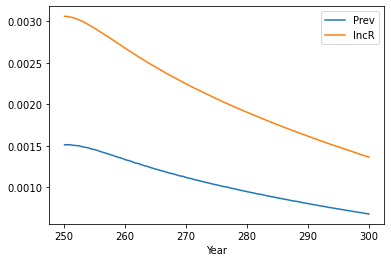

In [46]:
model = Model()

pars = {
    'beta': 30,
    'r_lat': 0.5,
    'r_act': 0.05,
    'r_react': 0.002,
    'r_rel': 0.002,
    'r_det': 2,
    'adr': 0.02,
    'mu': 0.02
}


meas = simulate(model, pars)
meas.plot() 

In [9]:
meas

,Year,Prev,IncR
0,0.0,0.000000e+00,1.000000e-06
1,0.1,9.044944e-08,9.979116e-07
2,0.2,1.641728e-07,9.958439e-07
3,0.3,2.242335e-07,9.937940e-07
4,0.4,2.730945e-07,9.917592e-07
...,...,...,...
296,29.6,2.763258e-07,5.529477e-07
297,29.7,2.757908e-07,5.518429e-07
298,29.8,2.752501e-07,5.507403e-07
299,29.9,2.747090e-07,5.496399e-07


In [17]:
30 / 0.1 + 1

301.0